# *keypoints*

En esta lección experimentaremos con la propiedad visual más importante: los "[puntos de interés](https://en.wikipedia.org/wiki/Interest_point_detection)", y veremos un ejemplo de reconocimiento de objetos usando sus "descriptores".

## bibliotecas y funciones

In [1]:
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

from matplotlib.pyplot   import imshow, subplot, title, plot

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) / 255

# para ver imágenes monocromas autoescalando el rango
def imshowg(x):
    imshow(x, 'gray')

# para ver imágenes monocromas de float con rango fijo
def imshowf(x):
    imshow(x, 'gray', vmin = 0, vmax=1)
    
# para ver imágenes con signo
def imshows(x,r=1):
    imshow(x, 'gray', vmin = -r, vmax=r)

## imagen de prueba

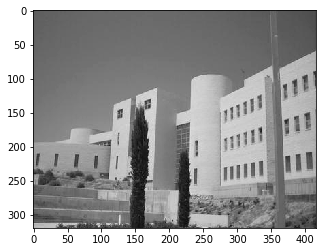

In [2]:
#img = readrgb('d2.jpg')[0:500,0:500]
img = readrgb('pano/pano001.jpg')

x = gray2float(rgb2gray(img))
imshowg(x)

## Hessian: detector de no linealidad

Las zonas de la imagen cuya superficie de color o nivel de gris es localmente plana no aportan mucha información. Corresponden a regiones uniformes o que cambian suavemente.

Una forma de detectar zonas interesantes es buscar segundas derivadas intensas. En concreto el determinante Hessiano indica la en qué medida es necesario un modelo cuadrático (no lineal) para modelar la superficie de imagen en un pequeño entorno de cada pixel.

La imagen siempre se analiza a una cierta escala. Para ello se hará un suavizado gaussiano previo. Es conveniente multiplicar por $\sigma$ para que el resultado del detector sea comparable a múltiples escalas.

In [3]:
def gaussian(s,x):
    return s * cv.GaussianBlur(x,(0,0), s)

Con el gradiente (primeras derivadas) y el Hessiano (segundas derivadas) construimos un modelo cuadrático en cada posición:

$$I(x) = I _ 0 + a \cdot x + \frac{1}{2} x ^ T H x $$

Los elementos de H son gxx, gyy, gxy, que calculamos mediante filtros de derivación.

In [4]:
def grad(x):
    gx = cv.Sobel(x,-1,1,0)
    gy = cv.Sobel(x,-1,0,1)
    return gx,gy

def grad2(x):
    gx,gy = grad(x)
    gxx,gxy = grad(gx)
    #gxx = cv.Sobel(x,-1,2,0); gxy = cv.Sobel(x,-1,1,1)
    gyy = cv.Sobel(gy,-1,0,1)
    #gyy = cv.Sobel(x,-1,0,2)
    return gx,gy,gxx,gyy,gxy

In [5]:
gx,gy,gxx,gyy,gxy = grad2(gaussian(3,x))
h = gxx*gyy-gxy**2

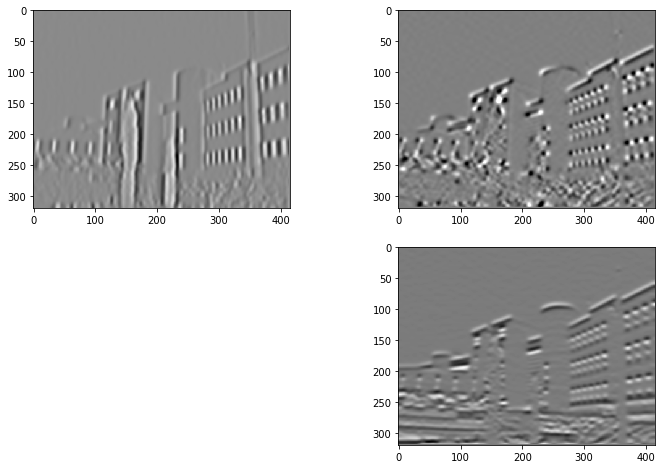

In [6]:
fig(12,8); 
subplot(2,2,1); imshowg(gxx); 
subplot(2,2,2); imshows(gxy); 
subplot(2,2,4); imshowg(gyy);

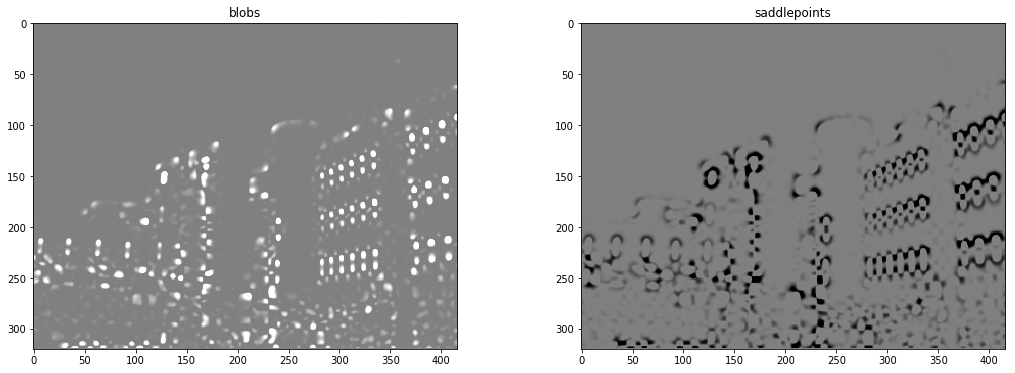

In [7]:
fig(18,6)
subplot(1,2,1)
imshows(np.maximum(0,h),1); title('blobs')
subplot(1,2,2)
imshows(np.minimum(0,h),1); title('saddlepoints');

Una forma rápida de encontrar los máximos del detector (*non maximum supression*) puede ser la siguiente:

In [8]:
def nms(x, t = 0.1):
    m = cv.dilate(x, np.ones((5,5),np.uint8))  # filtro de máximo
    h = np.max(m)
    return (x == m) & (x > t*h)

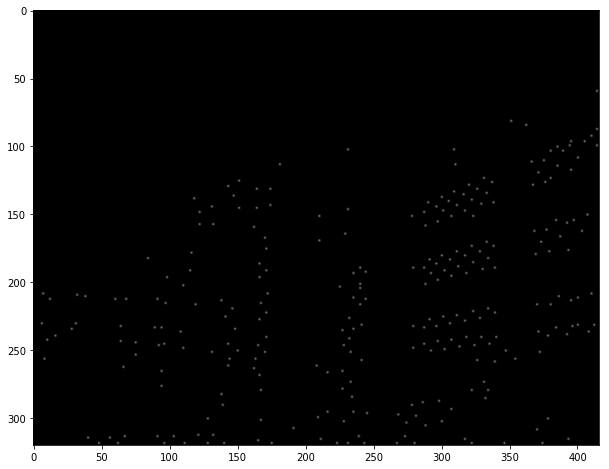

In [9]:
k = nms(-h)
fig(12,8)
#imshowg(k)
plt.imshow(k, 'gray', interpolation='bicubic');

Lo anterior es una imágen booleana. Es mucho mejor obtener las coordenadas de los puntos.

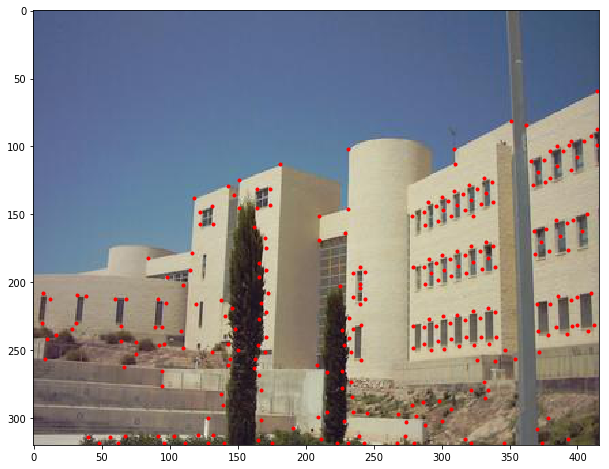

In [10]:
py,px = np.where(k)

fig(12,8)
imshow(img); ax = plt.axis();
plot(px,py,'.r'); plt.axis(ax);

Disgresión: los puntos de hessiano grande tienen la información relevante, son zonas no lineales y con ellas se puede reconstruir una versión aproximada de la imagen, de forma parecida a lo que hicimos con los bordes de Canny.

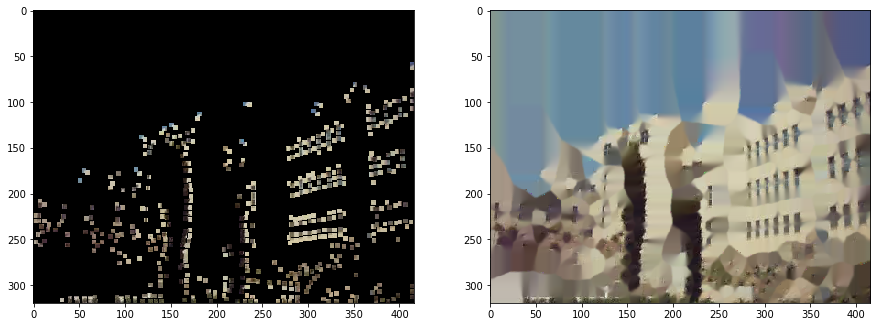

In [11]:
k = nms(abs(h),0.05)

mask = cv.dilate(k.astype(np.uint8), np.ones((5,5),np.uint8))
xx = img.copy()
xx[mask==0] = 0,0,0
dst = cv.inpaint(img,1-mask,3,cv.INPAINT_NS);

fig(15,6)
subplot(1,2,1); imshow(xx);
subplot(1,2,2); imshow(dst);

### espacio de escala

La intensidad del detector depende de la escala de análisis:

In [12]:
from ipywidgets import interactive

xb = gray2float(rgb2gray(readrgb('disk1.jpg')))

def fun(s):
    gx,gy,gxx,gyy,gxy = grad2(gaussian(s,xb))
    h = gxx*gyy-gxy**2
    imshowf(h);

interactive(fun, s=(1,20))    

interactive(children=(IntSlider(value=10, description='s', max=20, min=1), Output()), _dom_classes=('widget-interact',))

Esto sugiere la posibilidad de detectar automáticamente la escala óptima de cada punto. La idea es construir una ["pirámide"][1] de imágenes cada vez más suavizadas, y encontrar los puntos de ese espacio 3D $(x,y,\sigma)$ que son máximos locales (los que tienen una respuesta mayor que sus 9 vecinos).

[1]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

En lugar de calcular el Hessiano es más eficiente calcular el Laplaciano,con un truco matemático que permite calcularlo como diferencia de dos niveles consecutivos de suavizado. Es el operador "DOG". 

Como ejemplo vamos a intentar detectar los círculos y su tamaño en la siguiente imagen:

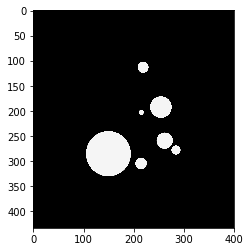

In [13]:
xc = cv.resize(readrgb('circles.jpg'),(0,0), fx=0.1, fy=0.1)

x = 1-np.pad(gray2float(rgb2gray(xc)),100,mode='constant',constant_values=1)
imshowg(x)

Creamos el espacio de escala. Para que el proceso sea más eficiente habría que ir reduciendo la imagen de tamaño, pero nosotros ahora no lo hacemos para poder comparar las etapas de forma directa.

In [14]:
pyr = np.array([gaussian(1.2**k,x) for  k in range(0,20)])

In [15]:
def fun(k=15):
    plt.imshow(pyr[k],'gray',vmin=pyr.min(),vmax=pyr.max());

interactive(fun, k=(0,19))    

interactive(children=(IntSlider(value=15, description='k', max=19), Output()), _dom_classes=('widget-interact',))

Ahora calculamos las diferencias entre ellas:

In [16]:
dog = np.array([xa-x for x,xa in zip(pyr,pyr[1:])])
dog.max(), dog.min()

(2.0749921811627683, -0.61599761801938513)

In [17]:
def fun(k=14):
    plt.imshow(dog[k],'gray',vmin=dog.min(),vmax=dog.max());

interactive(fun, k=(0,18))    

interactive(children=(IntSlider(value=14, description='k', max=18), Output()), _dom_classes=('widget-interact',))

Los puntos interesantes son los extremos locales en este bloque 3D. Afortunadamente tenemos una función que nos permite programar el *nonmaximum supression* multidimensional de forma inmediata.

In [18]:
import scipy.ndimage

In [19]:
ks = scipy.ndimage.maximum_filter(dog,3)

In [20]:
s,r,c = np.where((ks==dog) & (dog > 0.3))
s,r,c

(array([ 6,  7,  7,  9, 10, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17, 17,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18]),
 array([278, 114, 304, 259, 192, 263, 305, 309, 312, 318, 320, 260, 281,
        187, 283, 163, 164, 165, 167, 169, 176, 181, 182, 185, 285, 175,
        177, 179, 227, 157, 171, 226, 158, 225, 249, 249, 252, 260, 262,
        265, 269, 273, 291, 297, 301, 305, 307, 310, 312, 314, 316, 319, 339]),
 array([284, 218, 214, 261, 254, 281, 231, 230, 229, 223, 218, 283, 266,
        227, 263, 261, 264, 267, 270, 273, 279, 226, 282, 283, 150, 283,
        284, 285, 255, 233, 286, 274, 224, 285,  99, 209,  97,  93,  92,
         91,  90,  89,  88,  89,  90,  91,  92,  93,  94,  95,  96,  98, 180]))

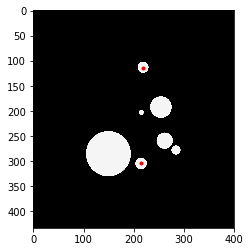

In [21]:
sc = 7
imshowg(x);
plt.plot(c[s==sc],r[s==sc],'.r');

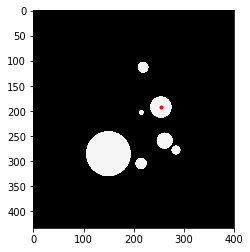

In [22]:
sc = 10
imshowg(x);
plt.plot(c[s==sc],r[s==sc],'.r');

## SIFT: scale invariant feature transform

Es uno de los [métodos más conocidos](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) para extraer puntos de interés. Obtiene puntos característicos con una escala y orientación, y con un *descriptor* de apariencia que permite calcular coincidencias entre puntos de diferentes imágenes. Esto permite resolver muchos problemas de visión artificial, tanto de reconocimiento de objetos como de geometría visual. La detección se basa en máximos locales del Hessiano en el espacio de escala aprovechando el método DOG anterior, y el descriptor es un histograma de gradientes orientados.

Para calcular a la vez los puntos y los descriptores usamos `detectAndCompute`. Los puntos son estructuras con los campos que se muestran en el siguiente trozo de código, y los descriptores se devuelven como filas de un array.

In [23]:
method = cv.xfeatures2d.SIFT_create()

kp,desc = method.detectAndCompute(img, mask=None)

xs = [ p.pt[0] for p in kp]
ys = [ p.pt[1] for p in kp]
sc = [ p.size  for p in kp]
rs = [ p.angle for p in kp]

print(len(kp))
print(desc.shape)

619
(619, 128)


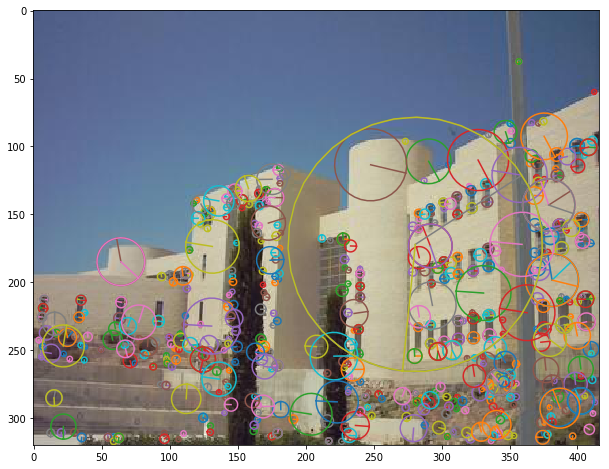

In [24]:
# para mostrar un keypoint, con su tamaño y orientación
def shkeypoint(k):
    t = np.linspace(k.angle,360+k.angle,36)*np.pi/180
    xs = k.pt[0]+k.size*np.cos(t)
    ys = k.pt[1]+k.size*np.sin(t)
    plot(np.append(k.pt[0],xs),np.append(k.pt[1],ys))

fig(12,8)
imshow(img); ax = plt.axis();
for k in kp:
    if k.size > 0:
        shkeypoint(k)
plt.axis(ax);

### image matching using keypoints

Una aplicación directa es el reconocimiento de imágenes.

In [25]:
import glob
def readfiles(path):
    return [readrgb(file) for file in sorted(glob.glob('../images/'+path))]

imgs = readfiles('sift/tests/*.*')
mods = readfiles('sift/models/*.*')

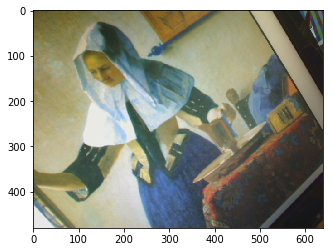

In [26]:
imshow(imgs[1]);

In [27]:
method = cv.xfeatures2d.SIFT_create()

dis = [method.detectAndCompute(x,None)[1] for x in imgs]
dms = [method.detectAndCompute(x,None)[1] for x in mods]

Las coincidencias de keypoints se calculan típicamente con un ["matcher"](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html) y luego se filtran para dejar solo las que que no tengan ambigüedad. Una forma de hacer esto es la siguiente (*ratio test*): se descartan los puntos cuya mejor coincidencia es parecida a la segunda mejor.

In [28]:
# por fuerza bruta
bf = cv.BFMatcher()


# fast approximate nearest neighbor
# pip install opencv-contrib-python

#FLANN_INDEX_KDTREE = 0
#index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#search_params = dict(checks=50)   # or pass empty dictionary
#flann = cv.FlannBasedMatcher(index_params,search_params)

modelo: 38266,  imagen: 415
coincidencias: 3 (0.7%)


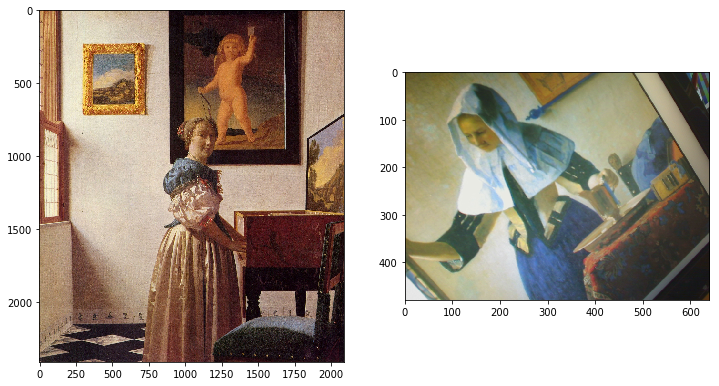

In [29]:
m = 2
t = 1

print('modelo: {},  imagen: {}'.format(len(dms[m]), len(dis[t])))

fig(12,8)
subplot(1,2,1); imshow(mods[m]);
subplot(1,2,2); imshow(imgs[t]);

#                     query  model  num de vecinos
matches = bf.knnMatch(dis[t],dms[m],k=2)
#matches = flann.knnMatch(dis[t],dms[m],k=2)    

# ratio test
good = []
for best, second in matches:
    if best.distance < 0.75*second.distance:
        good.append(m)
        
print('coincidencias: {} ({:.1f}%)'.format(len(good),100*len(good)/len(dis[t])))

Cambiando el modelo `m` y la imagen de prueba `t` podemos comprobar que el número de puntos coincidentes puede servir para reconocer objetos con suficiente textura. 

Estructura de matches (pendiente)

**Ejercicio**: representa gráficamente las coincidencias con `cv.drawMatches` para conseguir un resultado similar al obtenido en ejemplo de SIFT online realizado en el laboratorio.

### keypoints en OpenCV

OpenCV tiene muchos otros detectores de *keypoints*, que suelen utilizarse con un interfaz común.

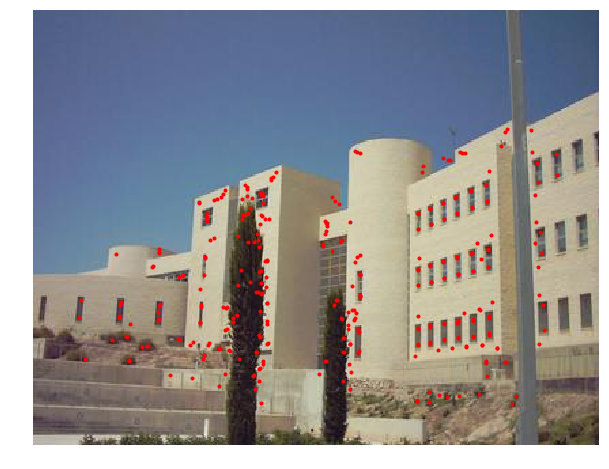

In [30]:
#method = cv.xfeatures2d.StarDetector_create()
#method = cv.FastFeatureDetector_create()
#method = cv.ORB_create()
#method = cv.xfeatures2d.SIFT_create()
#method = cv.xfeatures2d.SURF_create()
method = cv.AKAZE_create()

kp = method.detect(img)

xs = [ p.pt[0] for p in kp]
ys = [ p.pt[1] for p in kp]

fig(12,8)
imshow(img); ax = plt.axis('off');
plot(xs,ys,'.r'); plt.axis(ax);

Dependiendo de las necesidades de nuestra aplicación (velocidad de cálculo vs estabilidad de los puntos) elegiremos el más adecuado.

## bag of visual words

Si hay muchos modelos la búsqueda de coincidencias en todos ellos puede ser muy costosa computacionalmente. Una forma de acelerar el proceso es construir un "[vocabulario visual](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)" a partir de una gran colección de keypoints extraídos de los modelos disponibles o de escenas parecidas (mediante k-means o algún método parecido). Cada imagen se representa mediante un histograma que contabiliza el número de ocurrencias de cada "visual word". (Normalmente es un histograma muy disperso (*sparse*), con muchas celdas vacías). La comparación entre imágenes se reduce a comparar estos histogramas.